# Gradient descent -- SUGRA potential with 4 parameters and no exponentials

In this file, we

1) Read potentential from an external file

2) Choose the values for the parameters: 
    - Optimizer: e.g. Adam
    - n_points: Number of randomly initialised points
    - n_steps: Maximum number of steps in gradient descent algorithm
    - spread: size of the hypercube with initial data
    - alpha: initial learning rate
    - n_steps_opt: frequency with which the optimizer is rebooted
    - step_stop_opt: step from which the rebooting is cancelled

3) Perform gradient descent

4) Create /Output/ directory if unavailable and store:
    - Cloud of points and loss function into a .npy files
    - Ancillary file stating the choices above and showing the evolution of the learning process

5) Define visualisation functions


=========================

Changes since Oct 31st:

1) Directory of input file with potential changed
2) Number of variables 'dim' not defined in the notebook, but read from the input file

Changes since Nov 6th:

3) Gradient descent updated with optimiser rebooted every few steps

## Gradient Descent

In [44]:
import os
from importlib.machinery import SourceFileLoader

import numpy as np 
import tensorflow as tf

In [45]:
##############################
# Parameters
##############################

potential = "pot_4_param"                          # .py file with potential function V(x) and the number of variables 'dim'

time = np.datetime_as_string(np.datetime64('now'))
time = time.replace('-','_').replace('T','_at_').replace(':','_')

n_points = 10000                                       # Number of randomly initialised points
n_steps = 40000                                          # Maximum number of steps in gradient descent algorithm
spread = 2.2                                            # Initial values for the cloud of points in the hypercube [-spread/2, spread/2]^dim


alpha=10**(-3)              # Initial learning rate
n_steps_opt = 200           # Number of steps before rebooting optimizer
step_stop_opt = 1        


optimizer = tf.keras.optimizers.Adam(learning_rate=alpha)

optimizer_info = optimizer.get_config()

In [46]:
print(time)

2024_12_11_at_13_48_22


In [47]:
# Saving directory
out_dir = os.getcwd()+'/Output/'

try:
    os.mkdir(out_dir)
    print(f"Directory '{out_dir}' created successfully.")
except FileExistsError:
    print(f"Directory '{out_dir}' already exists.")
except PermissionError:
    print(f"Permission denied: Unable to create '{out_dir}'.")
except Exception as e:
    print(f"An error occurred: {e}")


# Output File names
attempt = f"_{potential}_{n_points}_{time}"

info_file = out_dir + 'Comments' + attempt + '.txt'
data_file = out_dir + 'Points' + attempt + '.npy'
loss_file = out_dir + 'Loss' + attempt + '.npy'


f_info = open(info_file, 'w')


f_info.write(f'File created on {time}')
f_info.write(f'\n\nPotential : {potential}')
f_info.write(f'\nNumber of points: {n_points}')
f_info.write(f'\nNumber of steps: {n_steps}\n')
f_info.write(f'\nn_steps_opt: {n_steps_opt}\n')
f_info.write(f'\nstep_stop_opt: {step_stop_opt}\n')
f_info.write('\nOptimizer:\n')


for key, value in optimizer_info.items(): 
    f_info.write('  - %s : %s\n' % (key, value))

f_info.write('\nEvolution:')
f_info.flush()

Directory '/home/camille/Documents/Science/MLFlatDirections/Output/' already exists.


In [48]:
# Loading the potential
module = SourceFileLoader(potential,os.getcwd()+'/Potential_generator/'+potential+'.py').load_module()
V = module.V
dim = module.dim

print(dim)
help(V)

4
Help on function V in module pot_4_param:

V(x)
    0.5 * (tf.exp(-6 * x7 -4 * (3 ** -0.5) * x9)) * (tf.exp(4 * x7) + tf.exp(12 * x7 + 4 * (3 ** -0.5) * x9) + 2 * (tf.exp(2 * x7 + 5 * (3 ** -0.5) * x9)) * (x1 ** 2) + 2 * (tf.exp(10 * x7 + (np.sqrt(3)) * x9)) * (x1 ** 2) + (tf.exp(8 * x7 + 2 * (3 ** -0.5) * x9)) * (-2 + x1 ** 4) + 2 * (tf.exp(2 * x7 + 2 * (3 ** -0.5) * x9)) * (x3 ** 2) + 2 * (tf.exp(10 * x7 + 2 * (np.sqrt(3)) * x9)) * (x3 ** 2) + (tf.exp(8 * x7 + 8 * (3 ** -0.5) * x9)) * (x3 ** 4) -4 * (tf.exp(6 * x7 + 4 * (3 ** -0.5) * x9)) * (-1 + x1 ** 2 + x3 ** 2) -2 * (tf.exp(4 * x7 + 2 * (np.sqrt(3)) * x9)) * (x3 ** 2) * (x1 ** 2 + x3 ** 2) + (tf.exp(4 * (3 ** -0.5) * x9)) * ((x1 ** 2 + x3 ** 2) ** 2) + 2 * (tf.exp(8 * x7 + 5 * (3 ** -0.5) * x9)) * (-2 + (x1 ** 2) * (x3 ** 2)) -2 * (tf.exp(4 * x7 + (np.sqrt(3)) * x9)) * (2 + x1 ** 4 + (x1 ** 2) * (x3 ** 2)))



In [49]:
# compute (||∇V||^2)
def grad_norm_squared(V, x):
    
    # Record operations for automatic differentiation:
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss = V(x)                                     # compute V at each point
    gradients = tape.gradient(loss, x)                  # compute ∇V at each point
    norm_squared = tf.reduce_sum(gradients**2, axis=1)  # ||∇V||^2 at each point
    return norm_squared

In [50]:
# Randomly initialize the points
x = tf.Variable(spread*np.random.rand(n_points, dim)-(spread/2), dtype=tf.float32)


loss_history = []


# Learning loop 
for step in range(n_steps):  
    with tf.GradientTape() as tape:
        loss = tf.reduce_sum(grad_norm_squared(V, x))  # minimize ||∇V||^2 for all points
        loss_history.append(loss)
    
    # Compute ||∇V||^2 with respect to x
    gradients = tape.gradient(loss, [x])
        
    # Apply gradient descent for all points
    optimizer.apply_gradients(zip(gradients, [x]))
    
    # Update the information in info file
    if step % 500 == 0:
        f_info.write(f"\n  Step {step}: ||∇V||^2 = {loss.numpy()}")
        f_info.flush()
        
    if np.log(loss.numpy())/np.log(10)<-6: 
        f_info.write("\n\nConverged enough") 
        f_info.write(f"\n  Step {step}: ||∇V||^2 = {loss.numpy()}")
        break

f_info.close()

# Saving loss and final cloud of points
np.save(data_file,x)
np.save(loss_file,loss_history)

In [15]:
# # Randomly initialize the points
# x = tf.Variable(np.random.rand(n_points, 3)+1, dtype=tf.float32)


# loss_history = []

# update_opt = False


# # Learning loop 
# for step in range(n_steps):  
#     with tf.GradientTape() as tape:
#         loss = tf.reduce_sum(grad_norm_squared(V, x))  # minimize ||∇V||^2 for all points
#         loss_history.append(loss)
    
#     # Compute ||∇V||^2 with respect to x
#     gradients = tape.gradient(loss, [x])
        
#     # Apply gradient descent for all points
#     optimizer.apply_gradients(zip(gradients, [x]))
    
#     # Updates of optimizer
#     if update_opt and step % n_steps_opt ==0 :
#         print("Reinitializing the optimizer")
#         optimizer = tf.optimizers.Adam(learning_rate=alpha)

#     if step == step_stop_opt:
#         update_opt = False
    
#     if (step - step_stop_opt)%(3*n_steps_opt) == 0:
#         alpha = alpha/10
#         optimizer = tf.optimizers.Adam(learning_rate=alpha)


#     # Update the information in info file
#     if step % 500 == 0:
#         f_info.write(f"\n  Step {step}: ||∇V||^2 = {loss.numpy()}")
#         f_info.flush()
        
#     if np.log(loss.numpy())/np.log(10)<-8: 
#         f_info.write("\n\nConverged enough") 
#         f_info.write(f"\n  Step {step}: ||∇V||^2 = {loss.numpy()}")
#         break

# f_info.close()

# # Saving loss and final cloud of points
# np.save(data_file,x)
# np.save(loss_file,loss_history)

## Results

In [1]:
import os
from importlib.machinery import SourceFileLoader

import numpy as np 
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm

import tensorflow as tf

2025-01-24 11:27:52.173798: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-24 11:27:52.217139: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-24 11:27:52.228763: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-24 11:27:52.288947: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-24 11:27:53.335374: W tensorflow/compiler/tf2

### Functions

In [4]:
# compute (||∇V||^2)
def grad_norm_squared(V, x):
    
    # Record operations for automatic differentiation:
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss = V(x)                                     # compute V at each point
    gradients = tape.gradient(loss, x)                  # compute ∇V at each point
    norm_squared = tf.reduce_sum(gradients**2, axis=1)  # ||∇V||^2 at each point
    return norm_squared

In [5]:
def triangular_plot(chains):
    data=chains
    nsteps,ndim=chains.shape
    fig = plt.figure(figsize=(20,20))
    for i in range(ndim):
        ax = fig.add_subplot(ndim,ndim,i*ndim+i+1)
        
        ax.hist(data[:,i], 100, color="k", histtype="step")
        ax.set_title(f"x{i+1} counts")

    for i in range(ndim):
        for j in range(i):
            ax = fig.add_subplot(ndim,ndim,i*ndim+j+1)
            counts,xbins,ybins,image = ax.hist2d(data[:,j],data[:,i],bins=100, norm=LogNorm(), cmap = plt.cm.rainbow)
            plt.colorbar(image)
            ax.contour(counts.transpose(),extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]], linewidths=0.5, cmap = plt.cm.rainbow, levels = [1,100,1000,10000])
            ax.set_xlabel(f'x{j+1}')
            ax.set_ylabel(f'x{i+1}')
    plt.show()

def triangular_plot_axes_lim(chains,mask):
    data=chains
    nsteps,ndim=chains.shape
    fig = plt.figure(figsize=(20,20))
    for i in range(ndim):
        ax = fig.add_subplot(ndim,ndim,i*ndim+i+1)
        
        ax.hist(data[:,i], 100, color="k", histtype="step")
        ax.set_title(f"x{i+1} counts")

    for i in range(ndim):
        for j in range(i):
            ax = fig.add_subplot(ndim,ndim,i*ndim+j+1)
            counts,xbins,ybins,image = ax.hist2d(data[mask,j],data[mask,i],bins=100, norm=LogNorm(), cmap = plt.cm.rainbow)
            plt.colorbar(image)
            ax.contour(counts.transpose(),extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]], linewidths=0.5, cmap = plt.cm.rainbow, levels = [1,100,1000,10000])
            ax.set_xlabel(f'x{j+1}')
            ax.set_ylabel(f'x{i+1}')
            ax.set_xlim([np.min(data[:,j]), np.max(data[:,j])])
            ax.set_ylim([np.min(data[:,i]), np.max(data[:,i])])
    plt.show()
    
# def triangular_plot(chains,figname):
#     data=chains
#     nsteps,ndim=chains.shape
#     fig = plt.figure(figsize=(20,20))
#     for i in range(ndim):
#         ax = fig.add_subplot(ndim,ndim,i*ndim+i+1)
        
#         ax.hist(data[:,i], 100, color="k", histtype="step")
#         ax.set_title(f"x{i+1} counts")

#     for i in range(ndim):
#         for j in range(i):
#             ax = fig.add_subplot(ndim,ndim,i*ndim+j+1)
#             counts,xbins,ybins,image = ax.hist2d(data[:,j],data[:,i],bins=100, norm=LogNorm(), cmap = plt.cm.rainbow)
#             plt.colorbar(image)
#             ax.contour(counts.transpose(),extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]], linewidths=0.5, cmap = plt.cm.rainbow, levels = [1,100,1000,10000])
#             ax.set_xlabel(f'x{j+1}')
#             ax.set_ylabel(f'x{i+1}')
#     plt.savefig(figname)
#     plt.show()


def triangular_plot_slopes(chains):
    data=chains.numpy()
    nsteps,ndim=chains.shape
    fig = plt.figure(figsize=(15,15))
    for i in range(ndim):
        for j in range(i):
            ax=fig.add_subplot(ndim,ndim,ndim*i+j+1)
            those_slope0=np.extract(np.abs(data[:,0])>0.2,data[:,i]/data[:,j])
            those_slope=np.extract(np.abs(those_slope0)<10,those_slope0)
            ax.hist(those_slope,bins=100)
            ax.set_title(f"x{j}/x{i}")
    plt.show()

### Analysis

In [6]:
# Loading the potential
potential = "pot_4_param"                         # .py file with potential function V(x)
module = SourceFileLoader(potential,os.getcwd()+'/Potential_generator/'+potential+'.py').load_module()
V = module.V
dim = module.dim


out_dir = os.getcwd()+'/Output/'
time = '2024_12_11_at_13_48_22'
n_points = 10000

attempt = f"_{potential}_{n_points}_{time}"

data_file = out_dir + 'Points' + attempt + '.npy'
loss_file = out_dir + 'Loss' + attempt + '.npy'

In [7]:

x = tf.Variable(np.load(data_file), dtype=tf.float32)
loss_history = np.load(loss_file)

I0000 00:00:1737714485.588518  147178 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1737714485.661065  147178 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1737714485.661243  147178 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1737714485.662359  147178 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [8]:
for i in range(15):
    print(f"Number of points with ||∇V||^2 > {10**(-i)} : {sum(grad_norm_squared(V,x).numpy()>10**(-i))}")

Number of points with ||∇V||^2 > 1 : 0
Number of points with ||∇V||^2 > 0.1 : 0
Number of points with ||∇V||^2 > 0.01 : 4
Number of points with ||∇V||^2 > 0.001 : 35
Number of points with ||∇V||^2 > 0.0001 : 141
Number of points with ||∇V||^2 > 1e-05 : 371
Number of points with ||∇V||^2 > 1e-06 : 827
Number of points with ||∇V||^2 > 1e-07 : 1460
Number of points with ||∇V||^2 > 1e-08 : 2406
Number of points with ||∇V||^2 > 1e-09 : 3741
Number of points with ||∇V||^2 > 1e-10 : 5227
Number of points with ||∇V||^2 > 1e-11 : 6458
Number of points with ||∇V||^2 > 1e-12 : 7986
Number of points with ||∇V||^2 > 1e-13 : 8772
Number of points with ||∇V||^2 > 1e-14 : 9219


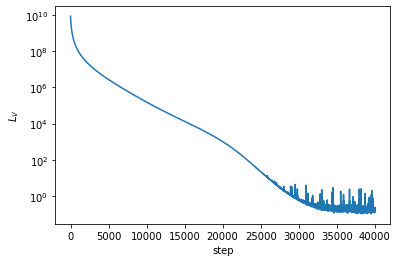

In [9]:
plt.figure(1)
plt.plot(loss_history)
plt.yscale('log')
plt.xlabel('step')
plt.ylabel('$L_{V}$')
plt.show()

<Figure size 432x288 with 0 Axes>

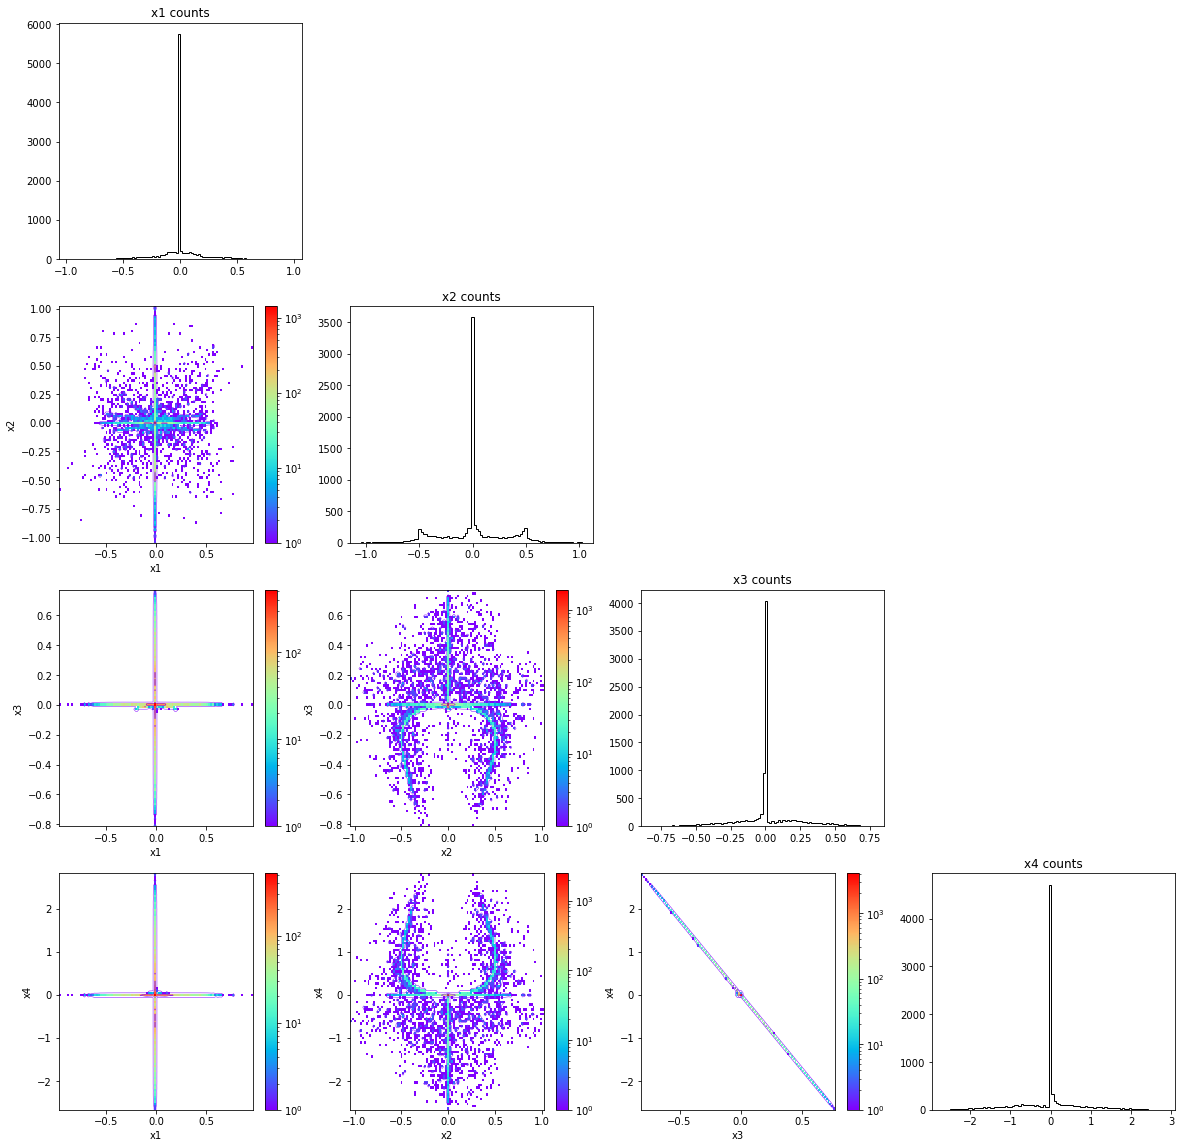

In [10]:
plt.figure(1)
triangular_plot(x.numpy())


In [11]:
xnp = x.numpy()

xnpfiltered=xnp[np.abs(xnp[:,3])>0.01]
xnpfiltered.shape

xnpfiltered2=xnp[np.abs(xnp[:,3])<=0.01]
xnpfiltered2.shape

(4407, 4)

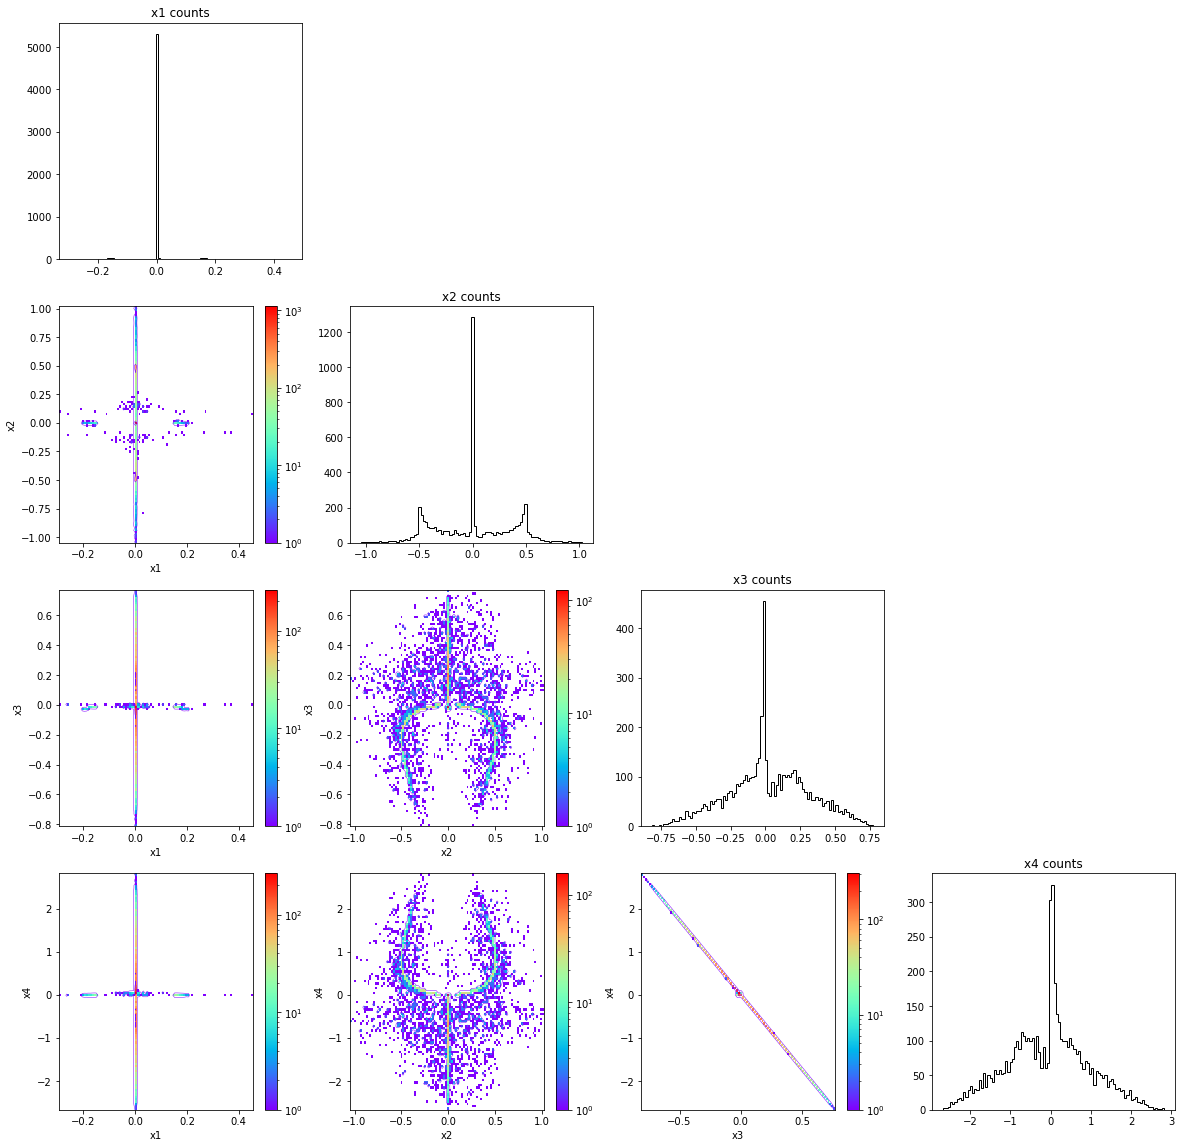

In [60]:
triangular_plot(xnpfiltered)

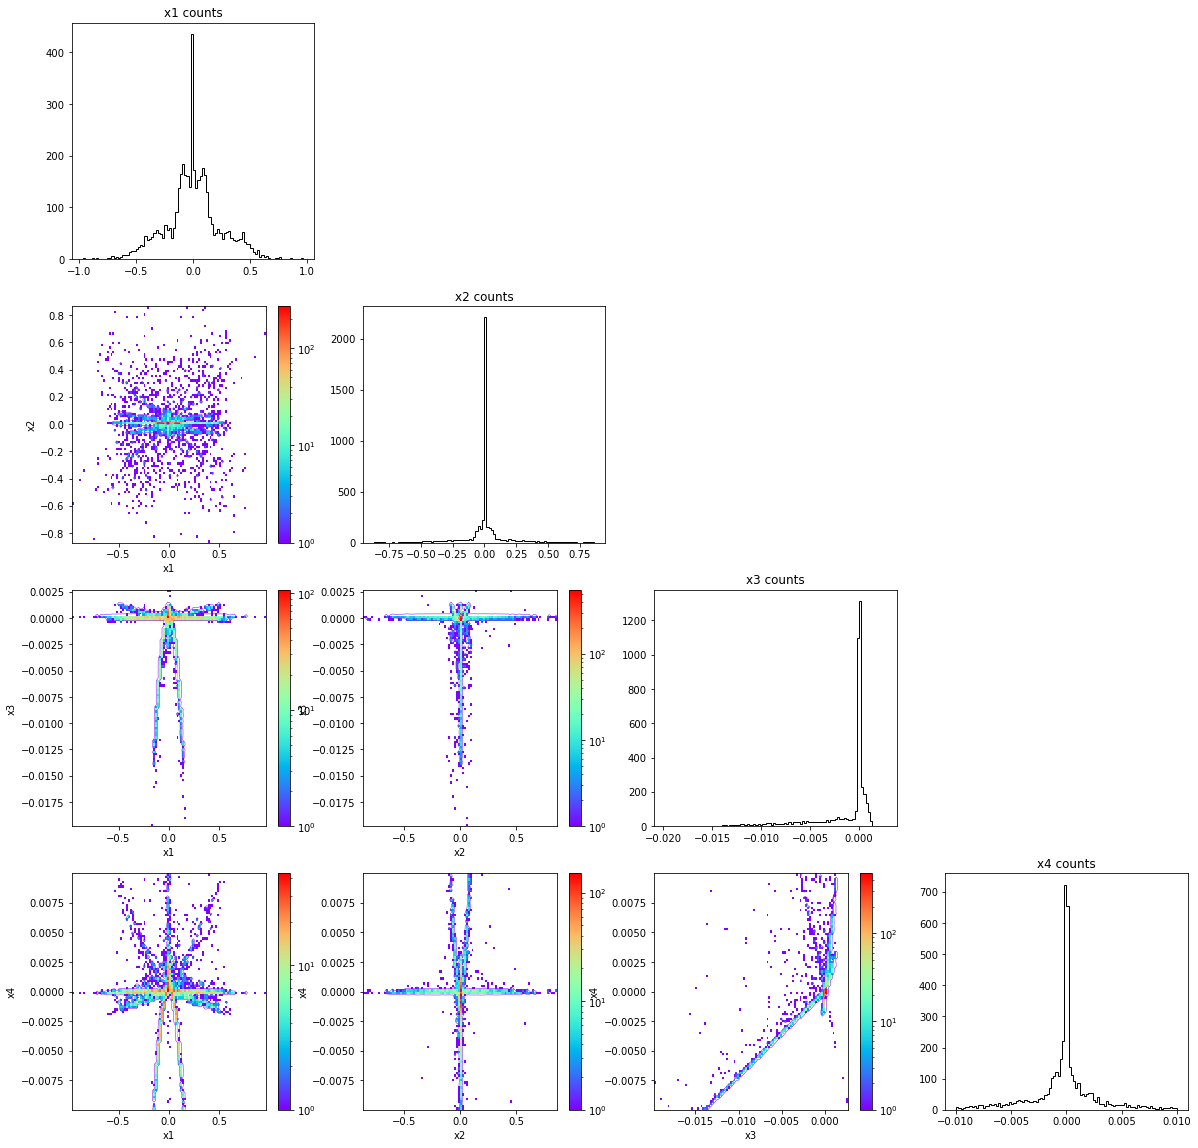

In [61]:
triangular_plot(xnpfiltered2)

# Autoencoder

In [12]:
import os
from importlib.machinery import SourceFileLoader


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model

In [13]:
# Loading the potential
potential = "pot_4_param"                         # .py file with potential function V(x)
module = SourceFileLoader(potential,os.getcwd()+'/Potential_generator/'+potential+'.py').load_module()
V = module.V
dim = module.dim


out_dir = os.getcwd()+'/Output/'
time = '2024_12_11_at_13_48_22'
n_points = 10000

attempt = f"_{potential}_{n_points}_{time}"

data_file = out_dir + 'Points' + attempt + '.npy'
loss_file = out_dir + 'Loss' + attempt + '.npy'
AE_loss_file = out_dir + 'AE_all_loss' + attempt + '.npy'
AE_val_loss_file = out_dir + 'AE_all_val_loss' + attempt + '.npy'

In [14]:
x = np.load(data_file)
loss_history = np.load(loss_file)

In [15]:
x_train, x_test = train_test_split(x, test_size=0.15, random_state=42)

In [16]:
print(f'shape of total set of points: {x.shape}')
print(f'shape of training set of points: {x_train.shape}')
print(f'shape of validation set of points: {x_test.shape}')

shape of total set of points: (10000, 4)
shape of training set of points: (8500, 4)
shape of validation set of points: (1500, 4)


## Determining the dimension of the conformal manifold

### Latent dimension = 1

In [29]:
input_dim = dim  
latent_dim = 1  

# Encoder
inputs = layers.Input(shape=(input_dim,))
encoded = layers.Dense(32, activation='sigmoid')(inputs)
encoded = layers.Dense(16, activation='sigmoid')(encoded)
encoded = layers.Dense(8, activation='sigmoid')(encoded)
encoded = layers.Dense(latent_dim)(encoded)  

# Decoder
decoded = layers.Dense(8, activation='sigmoid')(encoded)
decoded = layers.Dense(16, activation='sigmoid')(decoded)
decoded = layers.Dense(32, activation='sigmoid')(decoded)
decoded = layers.Dense(input_dim)(decoded)  

# Autoencoder 
autoencoder = models.Model(inputs, decoded)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=optimizer, loss='mse')

In [30]:
autoencoder.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 8)              │            16 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,669 (6.52 KB)

 Trainable params: 1,669 (6.52 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
epochs = 10000
history_AE_1 = autoencoder.fit(x_train, x_train, epochs=epochs, batch_size=100, shuffle=True,validation_data=(x_test, x_test))

Epoch 1/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.4897 - val_loss: 0.3624
Epoch 2/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3382 - val_loss: 0.2702
Epoch 3/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2659 - val_loss: 0.2194
Epoch 4/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2137 - val_loss: 0.1931
Epoch 5/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1975 - val_loss: 0.1807
Epoch 6/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1901 - val_loss: 0.1754
Epoch 7/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1814 - val_loss: 0.1735
Epoch 8/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1820 - val_loss: 0.1728
Epoch 9/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1770 - val_loss: 0.1727
Epoch 10/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1812 - val_loss: 0.1726
Epoch 11/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1875 - val_loss: 0.1726
Epoch 12/10000
85/85 ━━━━━━━━━━━━━━━━━━━━

In [32]:
autoencoder_1 = autoencoder
encoder_1 = models.Model(inputs,encoded)
decoder_1 = models.Model(encoded,decoded)

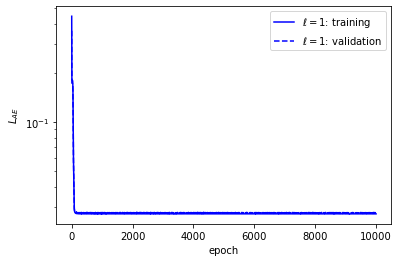

In [33]:
plt.plot(history_AE_1.history['loss'], label='$\ell=1$: training',color='blue')
plt.plot(history_AE_1.history['val_loss'], label='$\ell=1$: validation',color='blue',linestyle='--')
plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('$L_{AE}$')
plt.legend()

### Latent dimension = 2

In [34]:
input_dim = dim  
latent_dim = 2

# Encoder
inputs = layers.Input(shape=(input_dim,))
encoded = layers.Dense(32, activation='sigmoid')(inputs)
encoded = layers.Dense(16, activation='sigmoid')(encoded)
encoded = layers.Dense(8, activation='sigmoid')(encoded)
encoded = layers.Dense(latent_dim)(encoded)  

# Decoder
decoded = layers.Dense(8, activation='sigmoid')(encoded)
decoded = layers.Dense(16, activation='sigmoid')(decoded)
decoded = layers.Dense(32, activation='sigmoid')(decoded)
decoded = layers.Dense(input_dim)(decoded)  

# Autoencoder 
autoencoder = models.Model(inputs, decoded)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=optimizer, loss='mse')

In [35]:
autoencoder.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 2)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 8)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,686 (6.59 KB)

 Trainable params: 1,686 (6.59 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
epochs = 10000
history_AE_2 = autoencoder.fit(x_train, x_train, epochs=epochs, batch_size=100, shuffle=True,validation_data=(x_test, x_test))

Epoch 1/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.4245 - val_loss: 0.3053
Epoch 2/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2812 - val_loss: 0.2235
Epoch 3/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2120 - val_loss: 0.1891
Epoch 4/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1907 - val_loss: 0.1772
Epoch 5/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1832 - val_loss: 0.1737
Epoch 6/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1794 - val_loss: 0.1728
Epoch 7/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1754 - val_loss: 0.1725
Epoch 8/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1795 - val_loss: 0.1725
Epoch 9/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1767 - val_loss: 0.1724
Epoch 10/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1799 - val_loss: 0.1725
Epoch 11/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1779 - val_loss: 0.1724
Epoch 12/10000
85/85 ━━━━━━━━━━━━━━━━━━━━

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0060 - val_loss: 0.0067
Epoch 1647/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0059 - val_loss: 0.0068
Epoch 1648/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0061 - val_loss: 0.0067
Epoch 1649/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0060 - val_loss: 0.0068
Epoch 1650/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0060 - val_loss: 0.0067
Epoch 1651/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0061 - val_loss: 0.0067
Epoch 1652/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0062 - val_loss: 0.0067
Epoch 1653/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0060 - val_loss: 0.0068
Epoch 1654/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0059 - val_loss: 0.0068
Epoch 1655/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0062 - val_loss: 0.0068
Epoch 1656/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0060 - val_loss: 0.0068
Epoch 1657/10000
85/85 ━━━━

In [37]:
autoencoder_2 = autoencoder
encoder_2 = models.Model(inputs,encoded)
decoder_2 = models.Model(encoded,decoded)

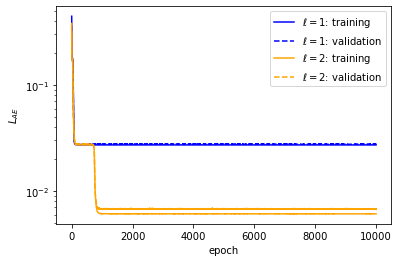

In [38]:
plt.plot(history_AE_1.history['loss'], label='$\ell=1$: training',color='blue')
plt.plot(history_AE_1.history['val_loss'], label='$\ell=1$: validation',color='blue',linestyle='--')
plt.plot(history_AE_2.history['loss'], label='$\ell=2$: training',color='orange')
plt.plot(history_AE_2.history['val_loss'], label='$\ell=2$: validation',color='orange',linestyle='--')
plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('$L_{AE}$')
plt.legend()

In [39]:
# test autoencoder
encoded_points = encoder_2.predict(x_test)

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


### Latent dimension = 3

In [40]:
input_dim = dim  
latent_dim = 3

# Encoder
inputs = layers.Input(shape=(input_dim,))
encoded = layers.Dense(32, activation='sigmoid')(inputs)
encoded = layers.Dense(16, activation='sigmoid')(encoded)
encoded = layers.Dense(8, activation='sigmoid')(encoded)
encoded = layers.Dense(latent_dim)(encoded)  

# Decoder
decoded = layers.Dense(8, activation='sigmoid')(encoded)
decoded = layers.Dense(16, activation='sigmoid')(decoded)
decoded = layers.Dense(32, activation='sigmoid')(decoded)
decoded = layers.Dense(input_dim)(decoded)  

# Autoencoder 
autoencoder = models.Model(inputs, decoded)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=optimizer, loss='mse')

In [41]:
autoencoder.summary()

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 3)              │            27 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 8)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,703 (6.65 KB)

 Trainable params: 1,703 (6.65 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
epochs = 10000
history_AE_3 = autoencoder.fit(x_train, x_train, epochs=epochs, batch_size=100, shuffle=True,validation_data=(x_test, x_test))

Epoch 1/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.6620 - val_loss: 0.4918
Epoch 2/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4693 - val_loss: 0.3573
Epoch 3/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3463 - val_loss: 0.2736
Epoch 4/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2731 - val_loss: 0.2240
Epoch 5/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2251 - val_loss: 0.1966
Epoch 6/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2005 - val_loss: 0.1827
Epoch 7/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1907 - val_loss: 0.1763
Epoch 8/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1829 - val_loss: 0.1737
Epoch 9/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1834 - val_loss: 0.1728
Epoch 10/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1788 - val_loss: 0.1725
Epoch 11/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1789 - val_loss: 0.1725
Epoch 12/10000
85/85 ━━━━━━━━━━━━━━━━━━━━

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0275 - val_loss: 0.0276
Epoch 655/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0271 - val_loss: 0.0276
Epoch 656/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0269 - val_loss: 0.0276
Epoch 657/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0275 - val_loss: 0.0276
Epoch 658/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0267 - val_loss: 0.0276
Epoch 659/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0277 - val_loss: 0.0276
Epoch 660/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0272 - val_loss: 0.0277
Epoch 661/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0275 - val_loss: 0.0276
Epoch 662/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0280 - val_loss: 0.0276
Epoch 663/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0276 - val_loss: 0.0276
Epoch 664/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0274 - val_loss: 0.0276
Epoch 665/10000
85/85 ━━━━━━━━━━━━━━━

In [43]:
autoencoder_3 = autoencoder
encoder_3 = models.Model(inputs,encoded)
decoder_3 = models.Model(encoded,decoded)

In [ ]:
AE_file = out_dir + 'AE_l3' + attempt + '.h5'

# Utiliser plutot .keras?

In [56]:
AE_file

'/home/camille/Documents/Science/MLFlatDirections/Output/AE_l3_pot_4_param_10000_2024_12_11_at_13_48_22.h5'

In [ ]:
# autoencoder_3.save(AE_file)

In [ ]:
# lossAE3_0 = history_AE_3.history['loss']
# val_lossAE3_0 = history_AE_3.history['val_loss']

# lossAE3_1 = history_AE_3.history['loss']
# val_lossAE3_1 = history_AE_3.history['val_loss']

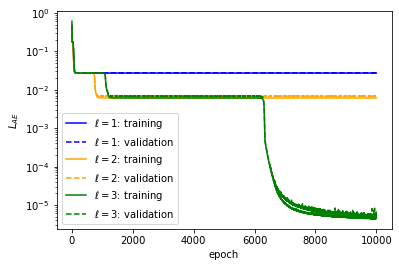

In [44]:
plt.plot(history_AE_1.history['loss'], label='$\ell=1$: training',color='blue')
plt.plot(history_AE_1.history['val_loss'], label='$\ell=1$: validation',color='blue',linestyle='--')
plt.plot(history_AE_2.history['loss'], label='$\ell=2$: training',color='orange')
plt.plot(history_AE_2.history['val_loss'], label='$\ell=2$: validation',color='orange',linestyle='--')
plt.plot(history_AE_3.history['loss'], label='$\ell=3$: training',color='green')
plt.plot(history_AE_3.history['val_loss'], label='$\ell=3$: validation',color='green',linestyle='--')
# plt.plot(lossAE3_0+lossAE3_1, label='$\ell=3$: training',color='green')
# plt.plot(val_lossAE3_0+val_lossAE3_1, label='$\ell=3$: validation',color='green',linestyle='--')

plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('$L_{AE}$')
plt.legend()

plt.show()

# plt.savefig('../LaTeX/Notes/Figures/lossAE_higgs.png')

### Latent dimension = 4

In [45]:
input_dim = dim  
latent_dim = 4

# Encoder
inputs = layers.Input(shape=(input_dim,))
encoded = layers.Dense(32, activation='sigmoid')(inputs)
encoded = layers.Dense(16, activation='sigmoid')(encoded)
encoded = layers.Dense(8, activation='sigmoid')(encoded)
encoded = layers.Dense(latent_dim)(encoded)  

# Decoder
decoded = layers.Dense(8, activation='sigmoid')(encoded)
decoded = layers.Dense(16, activation='sigmoid')(decoded)
decoded = layers.Dense(32, activation='sigmoid')(decoded)
decoded = layers.Dense(input_dim)(decoded)  

# Autoencoder 
autoencoder = models.Model(inputs, decoded)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=optimizer, loss='mse')

In [46]:
autoencoder.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,720 (6.72 KB)

 Trainable params: 1,720 (6.72 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
epochs = 10000
history_AE_4 = autoencoder.fit(x_train, x_train, epochs=epochs, batch_size=100, shuffle=True,validation_data=(x_test, x_test))

Epoch 1/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.2424 - val_loss: 0.1917
Epoch 2/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1942 - val_loss: 0.1757
Epoch 3/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1823 - val_loss: 0.1728
Epoch 4/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1780 - val_loss: 0.1725
Epoch 5/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1831 - val_loss: 0.1727
Epoch 6/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1864 - val_loss: 0.1726
Epoch 7/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1837 - val_loss: 0.1726
Epoch 8/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1752 - val_loss: 0.1725
Epoch 9/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1770 - val_loss: 0.1724
Epoch 10/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1787 - val_loss: 0.1724
Epoch 11/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1760 - val_loss: 0.1724
Epoch 12/10000
85/85 ━━━━━━━━━━━━━━━━━━━━

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0062 - val_loss: 0.0068
Epoch 1057/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0062 - val_loss: 0.0067
Epoch 1058/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0060 - val_loss: 0.0068
Epoch 1059/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0062 - val_loss: 0.0068
Epoch 1060/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0062 - val_loss: 0.0068
Epoch 1061/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0060 - val_loss: 0.0067
Epoch 1062/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0062 - val_loss: 0.0068
Epoch 1063/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058 - val_loss: 0.0068
Epoch 1064/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058 - val_loss: 0.0068
Epoch 1065/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0061 - val_loss: 0.0068
Epoch 1066/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0061 - val_loss: 0.0068
Epoch 1067/10000
85/85 ━━━━

In [48]:
autoencoder_4 = autoencoder
encoder_4 = models.Model(inputs,encoded)
decoder_4 = models.Model(encoded,decoded)

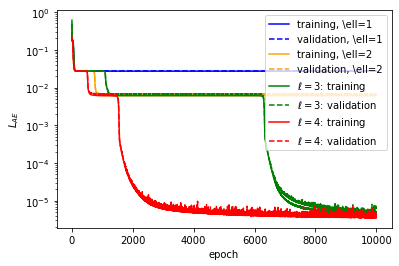

In [49]:
plt.plot(history_AE_1.history['loss'], label='training, \ell=1',color='blue')
plt.plot(history_AE_1.history['val_loss'], label='validation, \ell=1',color='blue',linestyle='--')
plt.plot(history_AE_2.history['loss'], label='training, \ell=2',color='orange')
plt.plot(history_AE_2.history['val_loss'], label='validation, \ell=2',color='orange',linestyle='--')
plt.plot(history_AE_3.history['loss'], label='$\ell=3$: training',color='green')
plt.plot(history_AE_3.history['val_loss'], label='$\ell=3$: validation',color='green',linestyle='--')
# plt.plot(lossAE3_0+lossAE3_1, label='$\ell=3$: training',color='green')
# plt.plot(val_lossAE3_0+val_lossAE3_1, label='$\ell=3$: validation',color='green',linestyle='--')
plt.plot(history_AE_4.history['loss'], label='$\ell=4$: training',color='red')
plt.plot(history_AE_4.history['val_loss'], label='$\ell=4$: validation',color='red',linestyle='--')

plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('$L_{AE}$')
plt.legend()

plt.show()

# plt.savefig('../LaTeX/Notes/Figures/lossAE_higgs.png')

In [ ]:
loss_history_all = np.array([history_AE_1.history['loss'],history_AE_2.history['loss'],history_AE_3.history['loss'],history_AE_4.history['loss']])
val_loss_history_all = np.array([history_AE_1.history['val_loss'],history_AE_2.history['val_loss'],history_AE_3.history['val_loss'],history_AE_4.history['val_loss']])

np.save(AE_loss_file,loss_history_all)
np.save(AE_val_loss_file,val_loss_history_all)

## Results and analysis of l = 3

### Loss functions

In [17]:
loss_history_all = np.load(AE_loss_file)
val_loss_history_all = np.load(AE_val_loss_file)

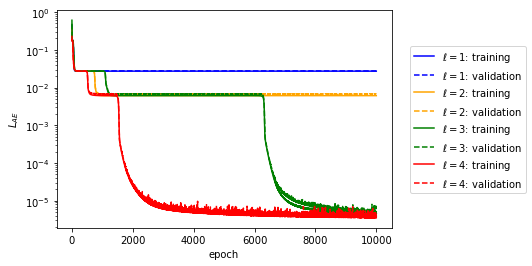

In [18]:
plt.plot(loss_history_all[0], label='$\ell=1$: training',color='blue')
plt.plot(val_loss_history_all[0], label='$\ell=1$: validation',color='blue',linestyle='--')
plt.plot(loss_history_all[1], label='$\ell=2$: training',color='orange')
plt.plot(val_loss_history_all[1], label='$\ell=2$: validation',color='orange',linestyle='--')
plt.plot(loss_history_all[2], label='$\ell=3$: training',color='green')
plt.plot(val_loss_history_all[2], label='$\ell=3$: validation',color='green',linestyle='--')
plt.plot(loss_history_all[3], label='$\ell=4$: training',color='red')
plt.plot(val_loss_history_all[3], label='$\ell=4$: validation',color='red',linestyle='--')

plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('$L_{AE}$')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")

plt.show()

### Analysis of the l = 3 autoencoder

In [19]:
AE_file = out_dir + 'AE_l3' + attempt + '.h5'

autoencoder_3 = models.load_model(AE_file, custom_objects={'mse': 'mse'})
autoencoder_3.summary()

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 3)              │            27 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 8)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,705 (6.66 KB)

 Trainable params: 1,703 (6.65 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [20]:
# Encoder
inputs = layers.Input(shape=(dim,))
encoded = autoencoder_3.layers[1](inputs)
encoded = autoencoder_3.layers[2](encoded)
encoded = autoencoder_3.layers[3](encoded)
encoded = autoencoder_3.layers[4](encoded)

encoder_3 = Model(inputs=inputs, outputs=encoded)

encoder_3.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 851 (3.32 KB)

 Trainable params: 851 (3.32 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Decoder
decoded = autoencoder_3.layers[5](encoded)
decoded = autoencoder_3.layers[6](decoded)
decoded = autoencoder_3.layers[7](decoded)
decoded = autoencoder_3.layers[8](decoded)

decoder_3 = Model(inputs=encoded, outputs=decoded)

decoder_3.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ keras_tensor_20CLONE            │ (None, 3)              │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 8)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 852 (3.33 KB)

 Trainable params: 852 (3.33 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# test autoencoder
encoded_points = encoder_3.predict(x)

I0000 00:00:1737714525.179473  147246 service.cc:146] XLA service 0x787c10004a90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737714525.179499  147246 service.cc:154]   StreamExecutor device (0): Quadro T2000 with Max-Q Design, Compute Capability 7.5
2025-01-24 11:28:45.186487: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-24 11:28:45.225085: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


197/313 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step

I0000 00:00:1737714525.524995  147246 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


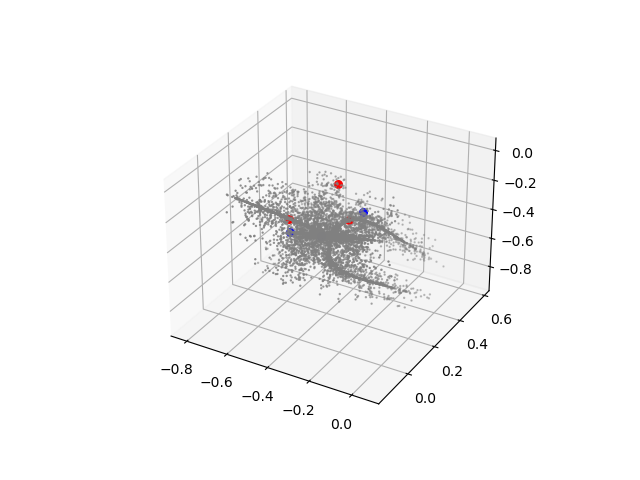

In [23]:
%matplotlib widget

# test=14

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(encoded_points[:,0], encoded_points[:,1], encoded_points[:,2],s=0.5,color='gray')
ax.scatter(encoded_points[6252,0], encoded_points[6252,1], encoded_points[6252,2],s=30,color='red')
ax.scatter(encoded_points[4684,0], encoded_points[4684,1], encoded_points[4684,2],s=30,color='red')
ax.scatter(encoded_points[1731,0], encoded_points[1731,1], encoded_points[1731,2],s=30,color='red')
ax.scatter(encoded_points[6775,0], encoded_points[6775,1], encoded_points[6775,2],s=30,color='blue')
ax.scatter(encoded_points[5272,0], encoded_points[5272,1], encoded_points[5272,2],s=30,color='blue')
ax.scatter(encoded_points[439,0], encoded_points[439,1], encoded_points[439,2],s=30,color='blue')
# ax.scatter(encoded_points[test,0], encoded_points[test,1], encoded_points[test,2],s=15,color='green')

We see two intersecting planes.

Find the equation of one plane

In [24]:
# Points in a given plane (see 3d plot)
A=encoded_points[6252]
B=encoded_points[4684]
C=encoded_points[1731]

# vectors in the plane
v1 = (A-B)
v1 = v1/np.sqrt(np.dot(v1,v1))

v2 = (A-C)
v2 = v2/np.sqrt(np.dot(v2,v2))

# normal vector
vn1 = np.cross(v1,v2)
vn1 = vn1/np.sqrt(np.dot(vn1,vn1))

# Equation of the plane
k1 = np.dot(vn1,A)
np.dot(C,vn1)-k1

0.0

In [25]:
mask1 = np.abs(np.dot(encoded_points,vn1)-k1)<5e-3

np.sum(mask1)

4634

Second plane

In [26]:
# Points in a given plane (see 3d plot)
A=encoded_points[6775]
B=encoded_points[439]
C=encoded_points[5272]

# vectors in the plane
v1 = (A-B)
v1 = v1/np.sqrt(np.dot(v1,v1))

v2 = (A-C)
v2 = v2/np.sqrt(np.dot(v2,v2))

# normal vector
vn2 = np.cross(v1,v2)
vn2 = vn2/np.sqrt(np.dot(vn2,vn2))

# Equation of the plane
k2 = np.dot(vn2,A)
np.dot(C,vn2)-k2

1.4901161e-08

In [27]:
mask2 = np.abs(np.dot(encoded_points,vn2)-k2)<5e-3

np.sum(mask2)

4171

In [28]:
np.sum(np.logical_or(mask1,mask2))

8214

We loose some points, but not too bad.

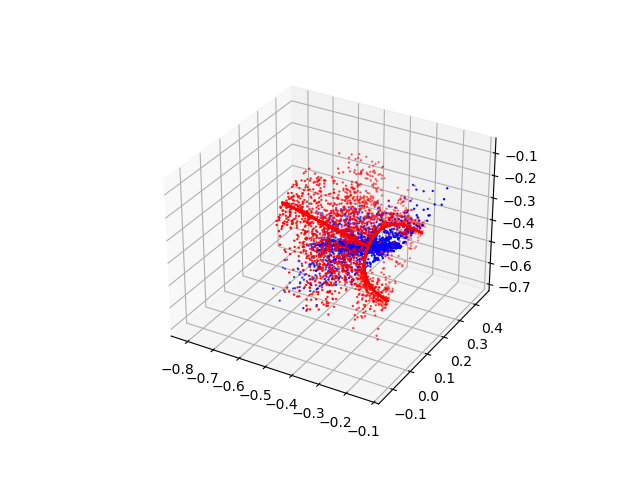

In [29]:
%matplotlib widget

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
# ax.scatter(encoded_points[np.logical_not(mask1),0], encoded_points[np.logical_not(mask1),1], encoded_points[np.logical_not(mask1),2],s=0.5)
ax.scatter(encoded_points[mask1,0], encoded_points[mask1,1], encoded_points[mask1,2],s=0.5,color='red')
ax.scatter(encoded_points[mask2,0], encoded_points[mask2,1], encoded_points[mask2,2],s=0.5,color='blue')

In [30]:
%matplotlib inline

<Figure size 432x288 with 0 Axes>

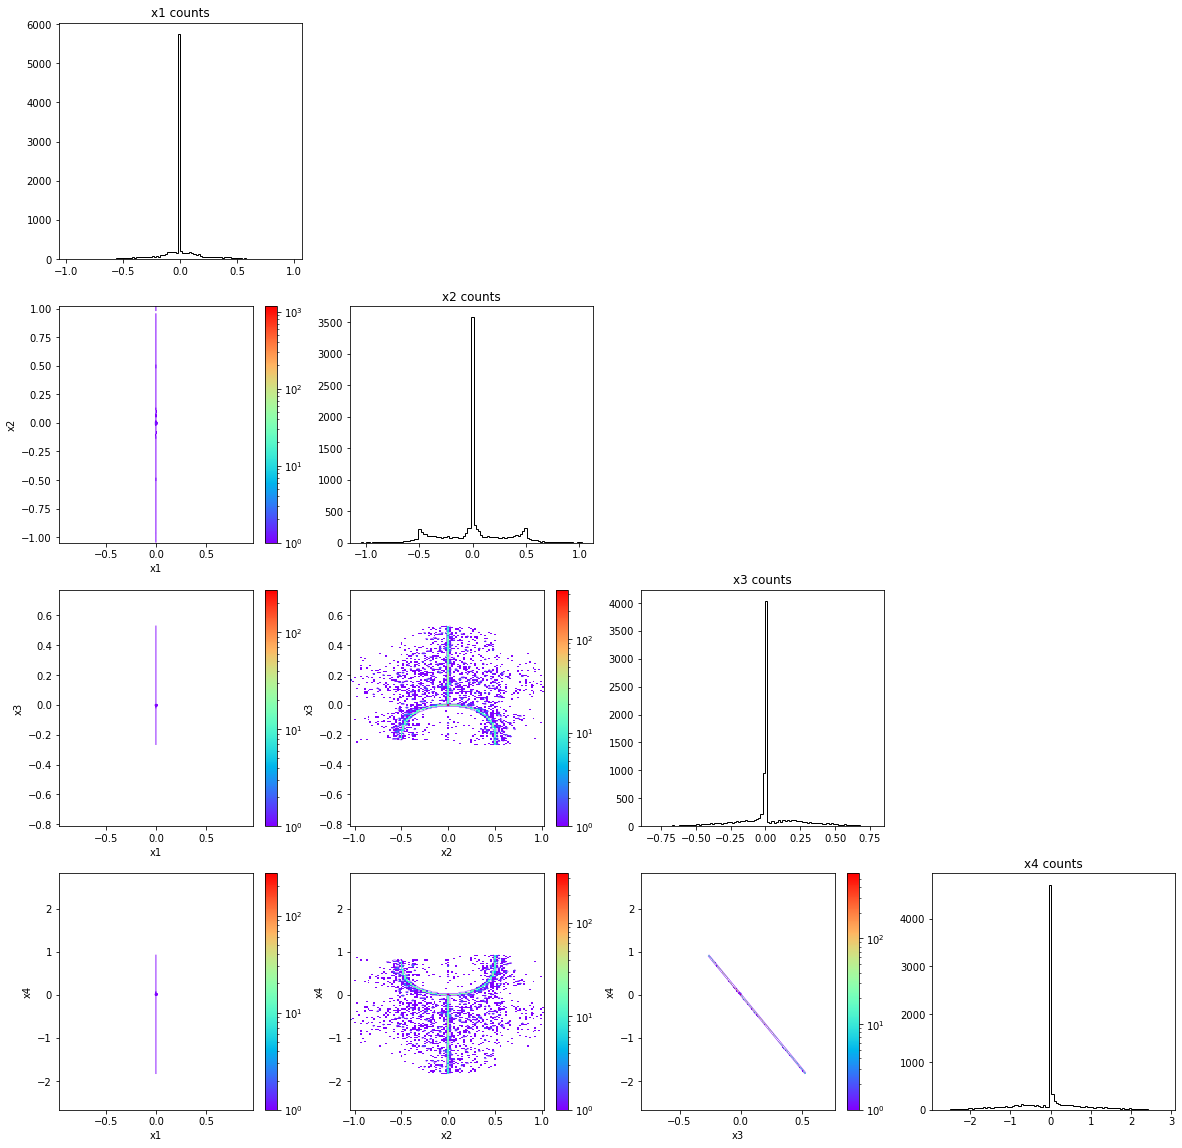

In [31]:
plt.figure(1)
triangular_plot_axes_lim(x,mask1)

<Figure size 432x288 with 0 Axes>

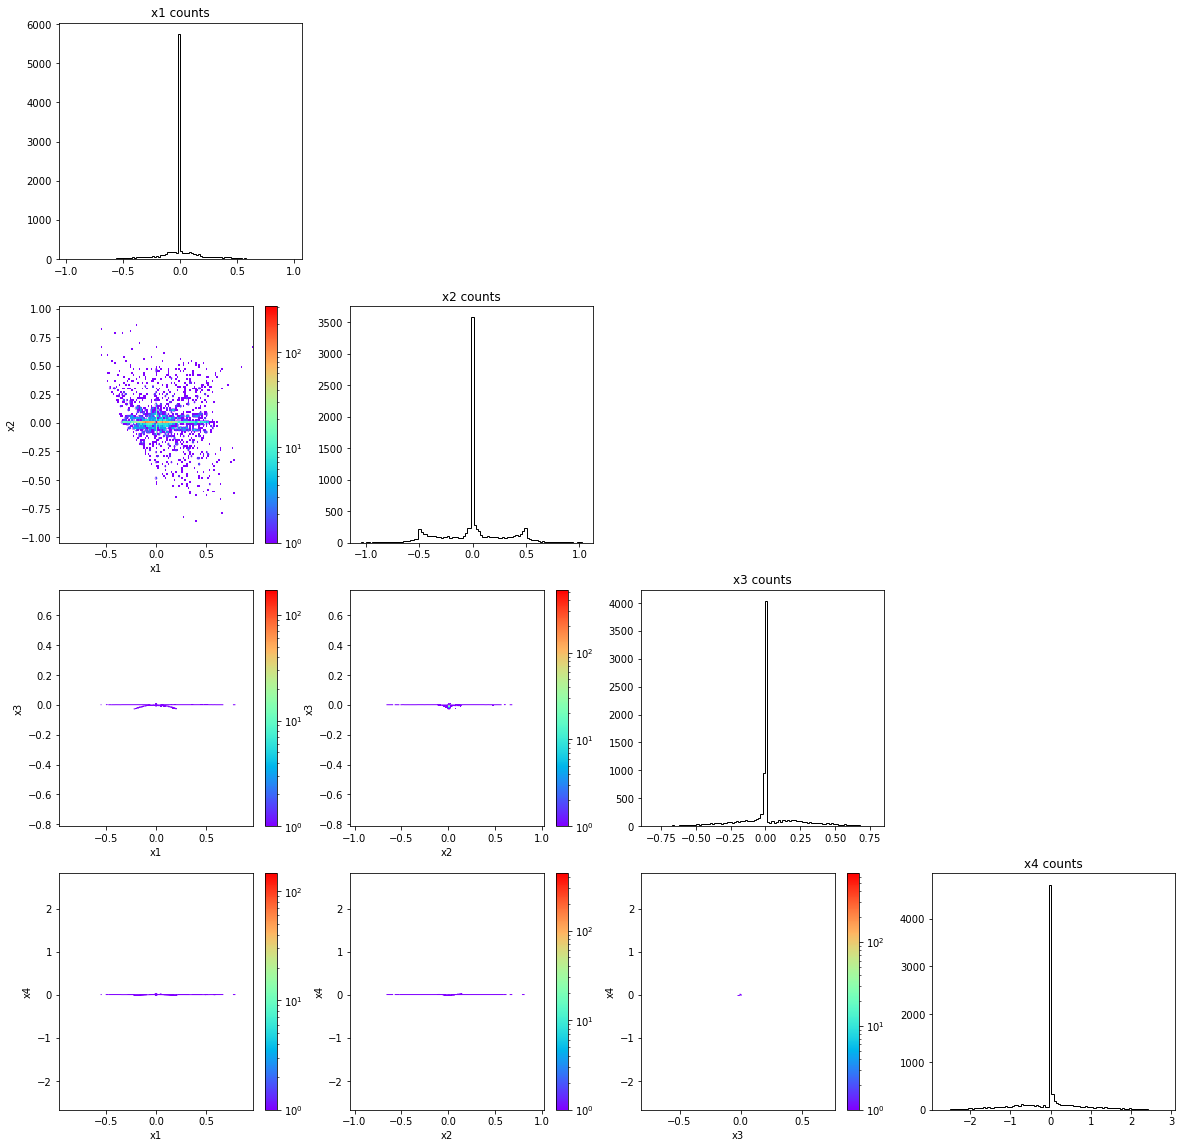

In [146]:
plt.figure(1)
triangular_plot_axes_lim(x,mask2)

In [23]:
np.min(x[:,0])
np.max(x[:,0])

0.96691984

### Learning the first plane

In [24]:
# Points in a given plane
A,B,C=x[mask1][np.random.randint(0,np.sum(mask1),3)]

# vectors in the plane
v1 = (A-B)
v1 = v1/np.sqrt(np.dot(v1,v1))

v2 = (A-C)
v2 = v2/np.sqrt(np.dot(v2,v2))

v3 = (B-C)
v3 = v3/np.sqrt(np.dot(v3,v3))

vec = [v1,v2,v3]

print(v1)
print(v2)
print(v3)

[-1.4934106e-34  1.7864537e-01  2.7292705e-01 -9.4530243e-01]
[-4.3327707e-34  6.1068672e-01  2.1962211e-01 -7.6080734e-01]
[-1.4915346e-35  6.6933706e-02 -2.7678561e-01  9.5859772e-01]


Define a list of pairs of vectors in the plane.

In [25]:
pairs = []
n = len(vec)
for i in range(n):
    for j in range(i+1, n):
        pairs.append((vec[i], vec[j]))

Select the two vectors with the smallest dot product.

In [26]:
selected_pair = pairs[np.argmin([np.abs(np.dot(pairs[i][0],pairs[i][1])) for i in np.arange(len(pairs))])]

np.dot(selected_pair[0],selected_pair[1])

-0.7492209

In [27]:
selected_pair

(array([-4.3327707e-34,  6.1068672e-01,  2.1962211e-01, -7.6080734e-01],
       dtype=float32),
 array([-1.4915346e-35,  6.6933706e-02, -2.7678561e-01,  9.5859772e-01],
       dtype=float32))

Find the vectors normal to the plane.

In [ ]:
# from sympy import solve
# from sympy.abc import w, v, y, z
# solve([np.dot([w,v,y,z],selected_pair[0]),np.dot([w,v,y,z],selected_pair[1])], [w, x, y, z], set=True)

([w, y],
 {(3.80846325319579e+33*v + 1.01293047112818e+29*z,
   0.866252255606102*v + 3.46410667259993*z)})

### Learning the second plane

In [46]:
# Points in a given plane
A,B,C=x[mask1][np.random.randint(0,np.sum(mask2),3)]

# vectors in the plane
v1 = (A-B)
v1 = v1/np.sqrt(np.dot(v1,v1))

v2 = (A-C)
v2 = v2/np.sqrt(np.dot(v2,v2))

v3 = (B-C)
v3 = v3/np.sqrt(np.dot(v3,v3))

vec = [v1,v2,v3]

print(v1)
print(v2)
print(v3)

[-7.7796512e-37  4.6611062e-01 -2.4537750e-01  8.5001808e-01]
[-1.5258185e-35  9.7933567e-01 -5.6083344e-02  1.9430996e-01]
[-1.4200801e-35  3.8203359e-01  2.5631920e-01 -8.8789129e-01]


In [47]:
pairs = []
n = len(vec)
for i in range(n):
    for j in range(i+1, n):
        pairs.append((vec[i], vec[j]))

In [48]:
selected_pair = pairs[np.argmin([np.abs(np.dot(pairs[i][0],pairs[i][1])) for i in np.arange(len(pairs))])]

np.dot(selected_pair[0],selected_pair[1])

0.18723777

In [49]:
selected_pair

(array([-1.5258185e-35,  9.7933567e-01, -5.6083344e-02,  1.9430996e-01],
       dtype=float32),
 array([-1.4200801e-35,  3.8203359e-01,  2.5631920e-01, -8.8789129e-01],
       dtype=float32))